In [22]:
from __future__ import print_function

import argparse
import numpy as np
import sys
sys.path.append("./src")
import os
from tqdm import tqdm
import csv
import time
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import training
from chainer.training import extensions, triggers
from dataset import CowcDataset_Counting
import random
import sys
sys.path.append('../..')
from tools.data_utils import gen_pins, gen_mesh_pins, count_pins
from tools.plot_utils import visualize_pins, plot_label_pin
from tools.models import DDPM, UNet
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
try:
    from PIL import Image
    available = True
except ImportError as e:
    available = False
    _import_error = e

In [23]:
from skimage import io
import torch
image_path = "/work/DNAL/Datasets/Cars/images/val/03553_1775_1571.png"
image = io.imread(image_path)
print(type(image), image.shape)
# New function
_, W, _ = image.shape
image = image[:, :W//2,  :]
# End of new function
image = image.transpose((2, 0, 1))
image = image/255 
image = torch.from_numpy(image)
image = transforms.functional.resize(image, (200,200))
image.shape

<class 'numpy.ndarray'> (800, 1600, 3)


torch.Size([3, 200, 200])

<class 'numpy.ndarray'> (200, 200, 3)


Text(0.5, 1.0, 'Image')

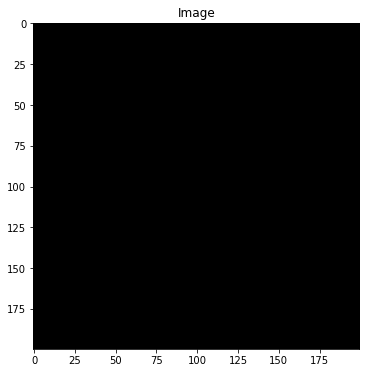

In [24]:
image = image.numpy()
# Plotting the image and mask side by side
fig, axs = plt.subplots(1, 1, figsize=(18, 6))
image = image.transpose(1, 2, 0)
print(type(image), image.shape)
# Plot the image
axs.imshow(image.astype(np.uint8))
#axs[0].axis('off')
axs.set_title('Image')

In [25]:
def _read_image_as_array(path, dtype):
    f = Image.open(path)
    try:
        image = np.asarray(f, dtype=dtype)
    finally:
        # Only pillow >= 3.0 has 'close' method
        if hasattr(f, 'close'):
            f.close()
    return image

In [26]:
def gen_mesh_pins(h, w, d):
    """
    Generate a list of mesh pins' coordinates within an image.

    Args:
    - h (int): The input image height.
    - w (int): The input image width.
    - d (int): The desired distance between mesh pins.

    Returns:
    - mesh_pins (list of tuples): A list of (x, y) coordinates representing mesh pins.

    This function takes an image and a specified distance 'd' as input and generates a grid of mesh pins within the image. The mesh pins are placed at regular intervals based on the given distance 'd'. The resulting list contains coordinate tuples, each representing the location of a mesh pin within the image.
    """
    # Initialize an empty list to store mesh pins
    mesh_pins = []

    # Iterate through the image and add mesh pins
    for y in range(0, h, d):
        for x in range(0, w, d):
            mesh_pins.append((x, y))
    
    # Randomize pins order
    new_order = np.random.permutation(len(mesh_pins))
    mesh_pins = [mesh_pins[i] for i in new_order]

    return mesh_pins

In [27]:
def gen_pins(h, w, n):
    """
    Generate a list of n unique random (x, y) coordinate pins within the dimensions of the image.

    Args:
    - h (int): The input image height.
    - w (int): The input image width.
    - n (int): Number of unique random pins to generate.

    Returns:
    unique_pins (list of tuples): List of (x, y) coordinate tuples representing unique random pins.
    """
    total_pixels = h * w

    # Ensure that n is not greater than the total number of pixels
    n = min(n, total_pixels)

    # Generate a list of all possible (x, y) coordinates
    all_possible_pins = [(x, y) for x in range(h) for y in range(w)]

    # Shuffle the list to randomize the order
    random.shuffle(all_possible_pins)

    # Select the first n coordinates to ensure uniqueness
    unique_pins = all_possible_pins[:n]
    return unique_pins

In [28]:
def count_within_radius(image, center_x, center_y, radius):
    """
    Count the number of pixels with value larger than 0 within a specified radius around a given pixel.

    Args:
    image (numpy.ndarray): Binary image where values greater than 0 represent the object and 0 the background.
    center_x (int): X-coordinate of the center pixel.
    center_y (int): Y-coordinate of the center pixel.
    radius (int): The radius within which to count adjacent ones.

    Returns:
    int: The count of adjacent ones within the specified radius around the center pixel.
    """
    h, w = image.shape
    
    # Define the bounding box
    x_min = max(center_x - radius, 0)
    x_max = min(center_x + radius + 1, h)
    y_min = max(center_y - radius, 0)
    y_max = min(center_y + radius + 1, w)

    # Extract the sub-array
    sub_image = image[x_min:x_max, y_min:y_max]

    # Create a mask for pixels within the circle
    y_indices, x_indices = np.ogrid[:sub_image.shape[0], :sub_image.shape[1]]
    dist_squared = (x_indices - (center_x - x_min)) ** 2 + (y_indices - (center_y - y_min)) ** 2
    circular_mask = dist_squared <= radius ** 2

    # Count the number of non-zero pixels within the mask
    return np.sum(sub_image[circular_mask])


In [29]:
def count_pins(mask, pins, radius):
    """
    Count the number of adjacent ones within a specified radius around a selection of points.

    Args:
    mask (numpy.ndarray): Binary image where 1 represents the object and 0 the background.
    pins (list of tuples): List of (x, y) coordinate tuples specifying the points of interest.
    radius (int): The radius within which to count adjacent ones.

    Returns:
    numpy.ndarray: An image with counts of adjacent ones within the specified radius around the points.
    """
    # Initialize an empty count image with the
    counted_pins = []
    for pin in pins:
        x, y = pin
        count = count_within_radius(mask, x, y, radius)
        counted_pins.append(count)  

    return counted_pins

In [30]:
def save_data(image_names, pins, labels, output_directory):
    """
    Save images, pin coordinates, and count labels to CSV.

    Args:
    image_names (list): List of image names.
    pins (list): List of lists of (x, y) coordinate tuples representing pin locations.
    labels (list): List of labels counted at the pin locations.
    output_directory (str): The directory where data, and count labels will be saved.

    Example usage:
    save_data(image_names, pins, labels, 'output_data')
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Save images with original name, and dump data to CSV
    with open(os.path.join(output_directory, 'pins.csv'), 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Write the header row
        csv_writer.writerow(['image', 'pins', 'outputs'])

        for i, (image_name, image_pins, label) in enumerate(zip(image_names, pins, labels)):
            # Write data to CSV
            csv_writer.writerow([image_name, image_pins, label])

    print("Data and images have been saved to the CSV and image files.")


In [31]:
def Cars(images_path, images, n_pin_max, r, n=-1, fixed_pins=True, mesh=False, d=1, store_path=f"./history/ddpm_MNIST.pt", n_steps=200):
    """
    Generate Cars dataset by selecting samples from the original CowcDataset and adding pins.

    Args:
    images_path (string): Path to the images
    images (string): List of files in the dataset to generate labels.
    n (int): Number of unique samples to select from the dataset, if -1, grab all the samples.
    n_pin_max (int): Maximum number of pins to generate for each sample.
    r (int): Radius for counting adjacent ones around each pin.
    fixed_pins (bool): If True, generates a fixed number of pins (n_pin_max) for all samples. If False, generates a random number of pins for each sample.
    mesh (bool): If True, generates pins on a mesh grid based on the 'd' parameter.
    d (int): Spacing between pins when 'mesh' is True.

    Returns:
    images (list): List of binary images in case of ddpm.
    pins (list): List of lists of (x, y) coordinate tuples.
    labels (list): List of count images where counts are the counted values at the pin locations.
    """
    
    # Select first n if n not -1
    if n != -1:
        images = images[:n]

    # Initialize lists to store pins and count images
    names = []
    pins = []
    labels = []
    
    total_start_time = time.time()
    read_image_time = 0
    generate_pins_time = 0
    count_pins_time = 0

    for i in tqdm(range(len(images)), desc="Processing images"):
        # Measure time for reading images
        start_time = time.time()
        car_image_path = os.path.join(images_path, images[i])
        car_image_mask_pair = _read_image_as_array(car_image_path, np.float64)
        read_image_time += time.time() - start_time

        _, W, _ = car_image_mask_pair.shape

        car_image = car_image_mask_pair[:, :W//2, :]
        mask = car_image_mask_pair[:, W//2:, 0]
        h, w, _ = car_image.shape

        # Measure time for generating pins
        start_time = time.time()
        if mesh:
            pin_locations = gen_mesh_pins(h, w, d)
        else:
            if fixed_pins:
                n_pins = n_pin_max
            else:
                n_pins = random.randint(1, n_pin_max)
            pin_locations = gen_pins(h, w, n_pin_max)
        generate_pins_time += time.time() - start_time

        # Measure time for counting pins
        start_time = time.time()
        label = count_pins(mask/255.0, pin_locations, r)
        count_pins_time += time.time() - start_time

        names.append(images[i])
        pins.append(pin_locations)
        labels.append(label)

        total_time = time.time() - total_start_time
        # Print profiling results
        #print(f"Total Time: {total_time:.2f} seconds")
        #print(f"Reading Images: {read_image_time:.2f} seconds")
        #print(f"Generating Pins: {generate_pins_time:.2f} seconds")
        #print(f"Counting Pins: {count_pins_time:.2f} seconds")


    return names, pins, labels


In [32]:
path = '../../../../Datasets/Cars/images'
label_path = '../../../../Datasets/Cars'
# Load mean image
mean = np.load(os.path.join(path, "mean.npy"))

# Load filenames
train_paths = os.path.join(path, "train.txt")
val_paths   = os.path.join(path, "val.txt")
test_paths  = os.path.join(path, "test.txt")
paths = [train_paths, val_paths, test_paths]

In [33]:
# Set number of images n and other hyperparameters to generate the PinMNIST dataset by changing the n_pins, fixed_pins, mesh, d and r
Npins = [500, 2000]
fixed_pins = True
ds = [20, 36]
r = 100
seed = 4
random.seed(seed)

In [34]:
(100/(28*28))*(200*200)

5102.040816326531

In [35]:
(200/9)**2

493.82716049382714

In [38]:
for folder in ["Cars"]:
    ext = ''
    if (folder.split("_")[-1] == "ddpm"):
        ext = '_ddpm'
    for i, mode in enumerate(['train', 'val', 'test']):  
        n = 1000 if mode == 'test' else -1
        print('Generating labels for', mode)
        with open(paths[i]) as paths_file:
            mode_paths = [path.rstrip() for path in paths_file]
        print('Processing ', len(mode_paths), ' images.')
        images_path = (os.path.join(path, mode))
        # Shuffle the original dataset
        random.shuffle(mode_paths)
        for d in ds:
            if mode == 'train':
                continue
            data_folder = f"{label_path}{ext}/{mode}/mesh_{d}step_{800}by{800}pixels_{r}radius_{seed}seed/"
            os.makedirs(data_folder, exist_ok=True)
            names, pins, labels = Cars(images_path, mode_paths, Npins[0], r, n, fixed_pins, mesh=True, d=d, store_path='')
            save_data(names, pins, labels, data_folder)
        for n_pins in Npins:
            if mode == 'train' and n_pins == 500:
                continue
            data_folder = f"{label_path}{ext}/{mode}/random_fixed{fixed_pins}_{n_pins}pins_{800}by{800}pixels_{r}radius_{seed}seed/"
            os.makedirs(data_folder, exist_ok=True)
            names, pins, labels = Cars(images_path, mode_paths, n_pins, r, n, fixed_pins, mesh=False, d=ds[0], store_path='')
            save_data(names, pins, labels, data_folder)

Generating labels for test
Processing  29501  images.


Processing images: 100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]


Data and images have been saved to the CSV and image files.


Processing images: 100%|██████████| 1000/1000 [01:50<00:00,  9.09it/s]


Data and images have been saved to the CSV and image files.


Processing images: 100%|██████████| 1000/1000 [09:36<00:00,  1.73it/s]


Data and images have been saved to the CSV and image files.


Processing images: 100%|██████████| 1000/1000 [13:10<00:00,  1.27it/s]


Data and images have been saved to the CSV and image files.


## How to load an image

In [18]:
def plot_image_and_mask(image, mask, radius=25):
    image = image.numpy()
    # Plotting the image and mask side by side
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    image = image.transpose(1, 2, 0)
    # Plot the image
    axs[0].imshow(image.astype(np.uint8))
    #axs[0].axis('off')
    axs[0].set_title('Image')

    h, w = mask.shape
    y, x = np.where(mask > 0)
    y = y // 4
    x = x // 4
    # Plot the mask
    #axs[1].axis('off')
    axs[1].set_title('Mask')
    axs[1].scatter(x, y, color='red', s=10, label='Car', alpha=1)
    axs[1].imshow(mask[0:200, 0:200], cmap='gray')
    
    # Plot the mask over the image
    axs[2].imshow(image.astype(np.uint8))
    axs[2].scatter(x, y, color='red', s=10, label='Car', alpha=0.7)
    #Plot empty circles on the mask
    for (xi, yi) in zip(x, y):
        circle = patches.Circle((xi, yi), radius=radius, edgecolor='blue', facecolor='none', linewidth=1)
        axs[2].add_patch(circle)
    axs[2].axis('off')
    axs[2].set_title('Mask over Image')

    plt.tight_layout()
    plt.show()

In [19]:
with open(os.path.join(path, "train.txt")) as paths_file:
    paths = [path.rstrip() for path in paths_file]
print('Example: ', paths[12])

Example:  03553_1025_10464.png


In [21]:
transpose_image = False
image_path = os.path.join(path, 'train', paths[78])
image_mask_pair = _read_image_as_array(image_path, np.float64)

_, W, _ = image_mask_pair.shape

image = image_mask_pair[:, :W//2,  :]
mask = image_mask_pair[:,  W//2:, 0]
# Crop image and mask
h, w, _ = image.shape

# Normalize if mean array is given
#image = (image - self._mean) / 255.0

# Remove car annotation outside the valid area
ignore = 4
label = (mask[ignore:-ignore, ignore:-ignore] > 0).sum()

# Type casting
#image = image.astype(dtype) 
#label = label_dtype(label)

# Transpose image from [h, w, c] to [c, h, w]
if transpose_image:
    image = image.transpose(2, 0, 1)

In [22]:
mask.shape

(800, 800)

In [136]:
non_zero_indices = np.nonzero(mask)
for idx in zip(*non_zero_indices):
    print(f"Position: {idx}, Value: {mask[idx]}")

Position: (93, 550), Value: 255.0
Position: (108, 503), Value: 255.0
Position: (125, 449), Value: 255.0
Position: (141, 395), Value: 255.0
Position: (158, 345), Value: 255.0
Position: (172, 300), Value: 255.0
Position: (185, 260), Value: 255.0
Position: (227, 147), Value: 255.0
Position: (240, 99), Value: 255.0
Position: (254, 49), Value: 255.0
Position: (278, 758), Value: 255.0
Position: (292, 720), Value: 255.0
Position: (303, 521), Value: 255.0
Position: (303, 679), Value: 255.0
Position: (319, 634), Value: 255.0
Position: (332, 599), Value: 255.0
Position: (338, 330), Value: 255.0
Position: (346, 554), Value: 255.0
Position: (387, 438), Value: 255.0
Position: (400, 400), Value: 255.0
Position: (404, 208), Value: 255.0
Position: (414, 358), Value: 255.0
Position: (426, 318), Value: 255.0
Position: (440, 277), Value: 255.0
Position: (453, 237), Value: 255.0
Position: (460, 75), Value: 255.0
Position: (469, 196), Value: 255.0
Position: (480, 154), Value: 255.0
Position: (498, 103), Va

(3, 800, 800)
torch.Size([3, 800, 800])
torch.Size([3, 800, 800])


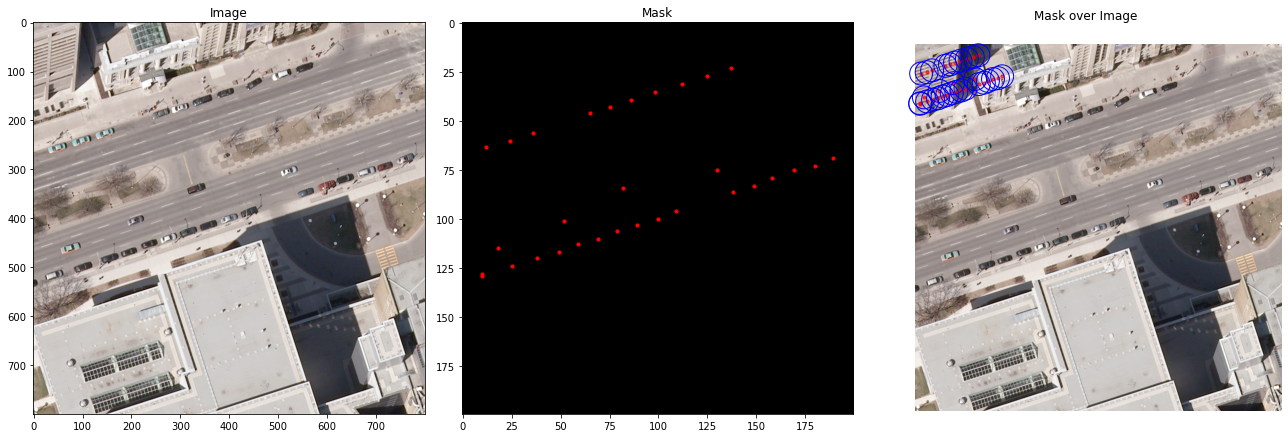

In [134]:
from torchvision import transforms
import torch
size=(800,800)
image = image.transpose(2, 0, 1)
print(image.shape)
pytorch_tensor = torch.from_numpy(image)
print(pytorch_tensor.shape)
pytorch_tensor = transforms.functional.resize(pytorch_tensor, size)
print(pytorch_tensor.shape)
# Assuming image and mask are already defined
plot_image_and_mask(pytorch_tensor, mask)

(3, 800, 800)
torch.Size([3, 800, 800])
torch.Size([3, 200, 200])


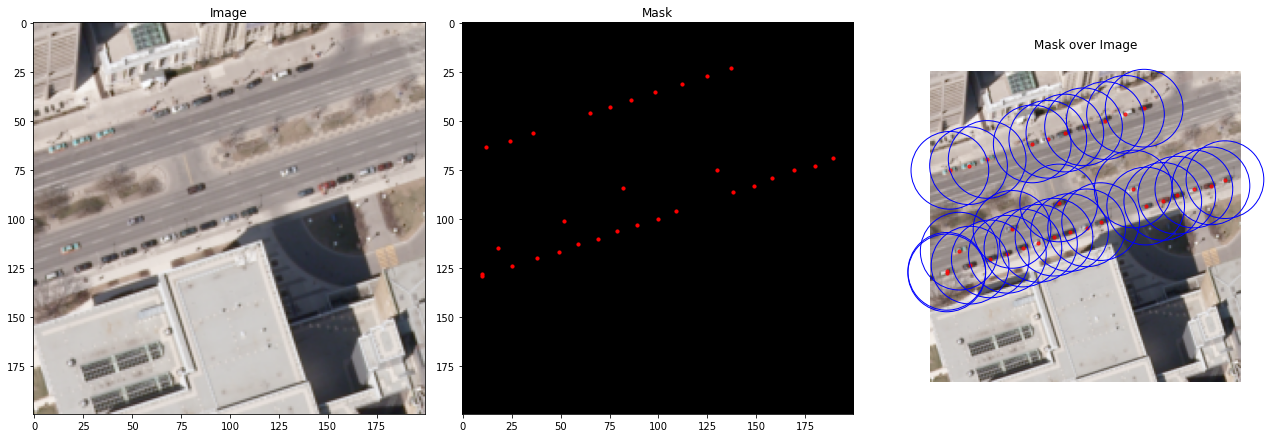

In [137]:
from torchvision import transforms
import torch
size=(200,200)
image = image.transpose(2, 0, 1)
print(image.shape)
pytorch_tensor = torch.from_numpy(image)
print(pytorch_tensor.shape)
pytorch_tensor = transforms.functional.resize(pytorch_tensor, size)
print(pytorch_tensor.shape)
# Assuming image and mask are already defined
plot_image_and_mask(pytorch_tensor, mask, 25)

## Dataset Check

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import json
from tools.plot_utils import plot_and_save
from tools.data_utils import *
import matplotlib.pyplot as plt
from torch.utils.data import Subset

In [4]:
# Choose datasets
dataset = 'Cars'
feature_extracted = False
n = 1000
mesh = False
d = 20 # 20 or 36
n_pins = 2000 # 500 or 2000
r = 100

# Set your hyperparameters
batch_size = 32
seed=4


In [5]:
if feature_extracted:
    # TO DO: Check how many features does the DDPM version has
    print('DDPM is still not available for this dataset')
else:
    input_channel = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if feature_extracted:
        folder = f"{dataset}_ddpm"
else:
    folder = f"{dataset}"
    
test_data_folder = f"/work/DNAL/Datasets/{folder}/test/random_fixedTrue_{n_pins}pins_{800}by{800}pixels_{r}radius_{seed}seed"
if mesh:
    train_data_folder = f"/work/DNAL/Datasets/{folder}/train/mesh_{d}step_{800}by{800}pixels_{r}radius_{seed}seed"
    val_data_folder = f"/work/DNAL/Datasets/{folder}/val/mesh_{d}step_{800}by{800}pixels_{r}radius_{seed}seed"
    config['n_pins'] = (800 // d + 1) ** 2
else: # Random pins 
    train_data_folder = f"/work/DNAL/Datasets/{folder}/train/random_fixedTrue_{n_pins}pins_{800}by{800}pixels_{r}radius_{seed}seed"
    val_data_folder = f"/work/DNAL/Datasets/{folder}/val/random_fixedTrue_{n_pins}pins_{800}by{800}pixels_{r}radius_{seed}seed"


In [7]:
transform = transforms.Compose([
        ExtractImage(), # Get image from image and mask combination
        ToTensor(),  # Convert to tensor (as you were doing)
        Resize200(),  # Resize to 200x200
    ])

In [8]:
root_dir=f"/work/DNAL/Datasets/{folder}/images/"
train_dataset = PinDataset(csv_file=f"{train_data_folder}/pins.csv",
                             root_dir=os.path.join(root_dir, 'train'), transform=transform, n=n)
val_dataset = PinDataset(csv_file=f"{val_data_folder}/pins.csv",
                             root_dir=os.path.join(root_dir, 'val'), transform=transform)
eval_dataset = PinDataset(csv_file=f"{test_data_folder}/pins.csv",
                             root_dir=os.path.join(root_dir, 'test'), transform=transform, n=n)

In [9]:
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

In [8]:
batch = next(iter(train_loader)) # batch['image'], batch['pins'], batch['outputs']

In [9]:
dec_batch = [*zip(batch['image'], batch['pins'], batch['outputs'])] # Deconstructed batch

In [12]:
def plot_image_and_mask(example, k=25, radius=25):
    image, pins, outputs = example
    image, pins, outputs = image.numpy(), pins.numpy(), outputs.numpy()
    n_pins = len(pins)
    ixs = random.sample(np.arange(n_pins).tolist(), k=k)
    if k != n_pins:
        pins, outputs = pins[ixs], outputs[ixs]
    # Plotting the image and mask side by side
    fig, axs = plt.subplots(3, 1, figsize=(18, 18))
    image = image.transpose(1, 2, 0)
    # Plot the image
    axs[0].imshow(image)
    #axs[0].axis('off')
    axs[0].set_title('Image')
    h, w, c = image.shape
    print(f'Image shape: {h}, {w}, {c}')
    y, x = [x for x, y in pins], [y for x, y in pins]
    assert all([type(y_c) == np.int64 for y_c in y])
    assert all([type(x_c) == np.int64 for x_c in x])
    #y = y // 4
    #x = x // 4
    # Plot the mask
    #axs[1].axis('off')
    axs[1].set_title('Mask')
    axs[1].scatter(x, y, color='red', s=10, label='Car', alpha=1)
    axs[1].imshow(np.ones((h, w)), cmap='gray')
    
    # Plot the mask over the image
    axs[2].imshow(image)
    axs[2].scatter(x, y, color='red', s=10, label='Car', alpha=0.7)
    #Plot empty circles on the mask
    for i, (xi, yi) in enumerate(zip(x, y)):
        circle = patches.Circle((xi, yi), radius=radius, edgecolor='blue', facecolor='none', linewidth=1)
        axs[2].add_patch(circle)
        axs[2].annotate(outputs[i], (xi, yi))
    axs[2].axis('off')
    axs[2].set_title('Mask over Image')

    plt.tight_layout()
    plt.show()

Image shape: 200, 200, 3


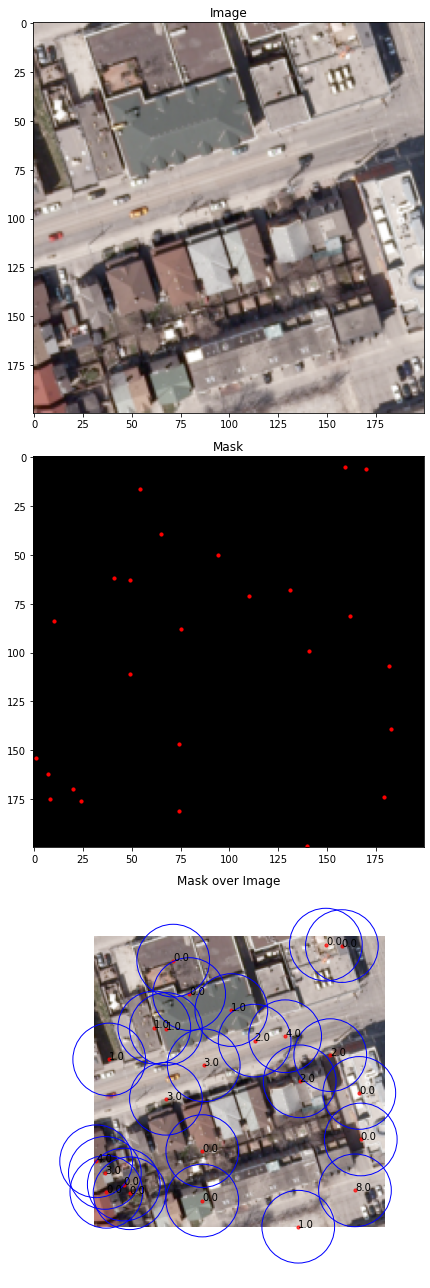

In [13]:
plot_image_and_mask(dec_batch[5])

### DDPM Features

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import json
from tools.plot_utils import plot_and_save
from tools.data_utils import *
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from skimage import io
import tqdm

ModuleNotFoundError: No module named 'tools'

In [ ]:
def extract_with_ddpm(data, n_steps, store_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load DDPM Model
    ddpm = DDPM(UNet(input_channels=3, shape=200), n_steps=n_steps, device=device, image_chw=(1, 200, 200))
    ddpm.load_state_dict(torch.load(store_path, map_location=device))
    
    # Move input to the same device as the model
    x0 = data.unsqueeze(0).to(device)
    n = len(x0)
    # Picking some noise for each of the images in the batch, a timestep, and the respective alpha_bars
    eta = torch.randn_like(x0).to(device)
    t = torch.randint(0, n_steps, (n,)).to(device)

    # Computing the noisy image based on x0 and the time-step (forward process)
    noisy_imgs = ddpm(x0, t, eta)

    # Getting model estimation of noise based on the images and the time-step
    eta_theta, concatenated_feature_map = ddpm.backward(noisy_imgs, t.reshape(n, -1))
    
    return concatenated_feature_map.squeeze()

In [41]:
base_path = '/work/DNAL/Datasets'
cars_dir = 'Cars'
ddpm_dir = 'Cars_ddpm'
splits = ['train', 'test', 'val']
n_samples = [1000, 400, 300]
n_steps=200
store_path = '../../history/ddpm_model_Cars.pt'
random.seed(42)
np.random.seed(42)

In [42]:
def process_image(image_value):
    # Remove .png termination and change it for .npy
    return image_value[:-4] + '.npy'

In [43]:
chosen_files = {}
test_images = pd.read_csv(os.path.join(base_path, cars_dir, 'test', 
                                       'random_fixedTrue_500pins_800by800pixels_100radius_4seed', 'pins.csv'))['image'].tolist()
# Loop through n_samples and splits
for n, split in zip(n_samples, splits):
    # Construct directory paths
    dir_path = os.path.join(base_path, cars_dir, split)
    im_path = os.path.join(base_path, cars_dir, 'images', split)
    ddpm_im_path = os.path.join(base_path, ddpm_dir, 'images', split)
    ddpm_split_path = os.path.join(base_path, ddpm_dir, split)
    
    # Create necessary directories, if they don't exist
    os.makedirs(ddpm_im_path, exist_ok=True)
    os.makedirs(ddpm_split_path, exist_ok=True)

    print(f"Directories created or already exist: {ddpm_im_path}, {ddpm_split_path}")
    
    # Get list of PNG files in the image directory
    try:
        if split == 'test':
            # Only 1000 images have pins data for test dataset
            png_files = test_images
        else:
            png_files = [f for f in os.listdir(im_path) if f.endswith('.png')]
        print(f"Found {len(png_files)} PNG files in {im_path}")
    except FileNotFoundError:
        print(f"Error: Directory {im_path} does not exist.")
        continue  # Skip this iteration if the directory is not found

    # Adjust n if it is larger than the number of PNG files
    n = min(n, len(png_files))
    print(f"Processing {n} files from {split}")

    # Randomly sample n files
    random_files = random.sample(png_files, n)
    chosen_files[split] = random_files
        
    # Process each image
    for image in tqdm.tqdm(random_files):
        # Get image name without extension
        image_name = image[:-4]
        #print(f"Processing image: {image_name}")

        # Construct full image path
        image_path = os.path.join(im_path, image)
        try:
            # Load image using skimage
            im = io.imread(image_path)
            #print(f"Loaded image {image_path} with shape {im.shape}")
        except FileNotFoundError:
            print(f"Error: Image file {image_path} not found.")
            continue  # Skip if image not found

        # Split the image width in half and take the left half
        _, W, _ = im.shape
        im = im[:, :W // 2, :]
        
        # Transpose to set channel as first dimension
        im = im.transpose((2, 0, 1))
        
        # Convert image to a tensor
        im = torch.from_numpy(im).float() / 255.0
        
        # Resize to fit model specifications
        im = transforms.functional.resize(im, (200,200))
        
        # Ensure image is still a float tensor
        im = im.to(torch.float32)
        
        # Process the image using DDPM
        ddpm_im = extract_with_ddpm(im, n_steps, store_path)
        
        # Construct the output image name with .npy extension
        image_name += ".npy"
        
        # Save the processed image if it doesn't already exist
        output_path = os.path.join(ddpm_im_path, image_name)
        if not os.path.exists(output_path):
            #print(f"Saving processed image {image_name} at {ddpm_im_path}")
            np.save(output_path, ddpm_im.detach().cpu().numpy())

    # Process pins (directories containing pins.csv)
    for root, dirs, files in os.walk(dir_path):
        for dir_name in dirs:
            if dir_name.startswith('.'):
                # Skip hidden directories
                continue
            mode_dir_path = os.path.join(root, dir_name)
            print(f"Processing directory: {mode_dir_path}")

            try:
                # Load the DataFrame from the CSV file
                df = pd.read_csv(os.path.join(mode_dir_path, 'pins.csv'))
                print(f"Loaded DataFrame with {len(df)} rows from {mode_dir_path}")
            except FileNotFoundError:
                print(f"Error: pins.csv not found in {mode_dir_path}.")
                continue  # Skip if CSV not found

            # Filter the DataFrame to include only images present in random_files
            filtered_df = df[df['image'].isin(random_files)]
            print(f"Filtered DataFrame contains {len(filtered_df)} rows after filtering by image list")
            filtered_df = filtered_df.copy()  # Create a copy of the slice
            # Apply image processing to the 'image' column
            filtered_df.loc[:, 'image'] = filtered_df['image'].apply(process_image)

            # Save the processed DataFrame to a new CSV file
            os.makedirs(os.path.join(ddpm_split_path, dir_name), exist_ok=True)
            output_csv_path = os.path.join(ddpm_split_path, dir_name, 'pins.csv')
            filtered_df.to_csv(output_csv_path, index=False)
            print(f"Processed CSV saved at {output_csv_path}")


Directories created or already exist: /work/DNAL/Datasets/Cars_ddpm/images/train, /work/DNAL/Datasets/Cars_ddpm/train
Found 15015 PNG files in /work/DNAL/Datasets/Cars/images/train
Processing 1000 files from train


100%|██████████| 1000/1000 [02:39<00:00,  6.28it/s]


Processing directory: /work/DNAL/Datasets/Cars/train/mesh_20step_800by800pixels_100radius_4seed
Loaded DataFrame with 15015 rows from /work/DNAL/Datasets/Cars/train/mesh_20step_800by800pixels_100radius_4seed
Filtered DataFrame contains 1000 rows after filtering by image list
Processed CSV saved at /work/DNAL/Datasets/Cars_ddpm/train/mesh_20step_800by800pixels_100radius_4seed/pins.csv
Processing directory: /work/DNAL/Datasets/Cars/train/mesh_36step_800by800pixels_100radius_4seed
Loaded DataFrame with 15015 rows from /work/DNAL/Datasets/Cars/train/mesh_36step_800by800pixels_100radius_4seed
Filtered DataFrame contains 1000 rows after filtering by image list
Processed CSV saved at /work/DNAL/Datasets/Cars_ddpm/train/mesh_36step_800by800pixels_100radius_4seed/pins.csv
Processing directory: /work/DNAL/Datasets/Cars/train/random_fixedTrue_2000pins_800by800pixels_100radius_4seed
Loaded DataFrame with 15015 rows from /work/DNAL/Datasets/Cars/train/random_fixedTrue_2000pins_800by800pixels_100rad

100%|██████████| 400/400 [01:06<00:00,  5.97it/s]


Processing directory: /work/DNAL/Datasets/Cars/test/mesh_20step_800by800pixels_100radius_4seed
Loaded DataFrame with 1000 rows from /work/DNAL/Datasets/Cars/test/mesh_20step_800by800pixels_100radius_4seed
Filtered DataFrame contains 400 rows after filtering by image list
Processed CSV saved at /work/DNAL/Datasets/Cars_ddpm/test/mesh_20step_800by800pixels_100radius_4seed/pins.csv
Processing directory: /work/DNAL/Datasets/Cars/test/mesh_36step_800by800pixels_100radius_4seed
Loaded DataFrame with 1000 rows from /work/DNAL/Datasets/Cars/test/mesh_36step_800by800pixels_100radius_4seed
Filtered DataFrame contains 400 rows after filtering by image list
Processed CSV saved at /work/DNAL/Datasets/Cars_ddpm/test/mesh_36step_800by800pixels_100radius_4seed/pins.csv
Processing directory: /work/DNAL/Datasets/Cars/test/random_fixedTrue_2000pins_800by800pixels_100radius_4seed
Loaded DataFrame with 1000 rows from /work/DNAL/Datasets/Cars/test/random_fixedTrue_2000pins_800by800pixels_100radius_4seed
Fil

100%|██████████| 300/300 [00:50<00:00,  5.99it/s]


Processing directory: /work/DNAL/Datasets/Cars/val/mesh_20step_800by800pixels_100radius_4seed
Loaded DataFrame with 661 rows from /work/DNAL/Datasets/Cars/val/mesh_20step_800by800pixels_100radius_4seed
Filtered DataFrame contains 300 rows after filtering by image list
Processed CSV saved at /work/DNAL/Datasets/Cars_ddpm/val/mesh_20step_800by800pixels_100radius_4seed/pins.csv
Processing directory: /work/DNAL/Datasets/Cars/val/mesh_36step_800by800pixels_100radius_4seed
Loaded DataFrame with 661 rows from /work/DNAL/Datasets/Cars/val/mesh_36step_800by800pixels_100radius_4seed
Filtered DataFrame contains 300 rows after filtering by image list
Processed CSV saved at /work/DNAL/Datasets/Cars_ddpm/val/mesh_36step_800by800pixels_100radius_4seed/pins.csv
Processing directory: /work/DNAL/Datasets/Cars/val/random_fixedTrue_2000pins_800by800pixels_100radius_4seed
Loaded DataFrame with 661 rows from /work/DNAL/Datasets/Cars/val/random_fixedTrue_2000pins_800by800pixels_100radius_4seed
Filtered DataF

### Load DDPM

In [6]:
import numpy as np
img_name = '/work/DNAL/Datasets/Cars_ddpm/images/val/03553_1779_1059.npy'
image = np.load(img_name)
print(image.shape)

(1, 73, 28, 28)


In [10]:
image

array([[[[-4.25940752e-03,  7.25887204e-03, -4.62899404e-03, ...,
          -7.25948140e-02, -8.30137655e-02, -5.87184243e-02],
         [-3.35536599e-02, -3.11299935e-02, -5.16751073e-02, ...,
          -1.16235591e-01, -1.21278979e-01, -8.36469382e-02],
         [-4.06167321e-02, -5.04187495e-02, -7.46923462e-02, ...,
          -1.50470942e-01, -1.57384172e-01, -1.17978863e-01],
         ...,
         [-4.80285697e-02, -7.54061192e-02, -9.42292064e-02, ...,
          -1.37064576e-01, -1.25328407e-01, -7.93131366e-02],
         [-4.61858325e-02, -7.16519505e-02, -9.23084095e-02, ...,
          -1.15597792e-01, -1.01103164e-01, -5.12015857e-02],
         [-5.62198274e-02, -7.97506198e-02, -9.88600701e-02, ...,
          -9.86273363e-02, -7.54627734e-02, -3.94160673e-02]],

        [[-1.76042225e-02, -5.31223118e-02, -6.93539903e-02, ...,
          -4.88751894e-03,  4.62038955e-03, -2.45349458e-03],
         [-4.38396335e-02, -7.65482262e-02, -1.08199313e-01, ...,
          -2.40324419e